<a href="https://www.kaggle.com/code/averma111/pytorch-ps3e15?scriptVersionId=130011811" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [137]:
%%capture 
!pip install optuna

In [138]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import torch
from tqdm.notebook import tqdm
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
warnings.filterwarnings('ignore')
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

In [139]:
def get_dataframe(path):
    df=pd.read_csv(path)
    return df

In [140]:
data = get_dataframe('/kaggle/input/playground-series-s3e15/data.csv')
original = get_dataframe('/kaggle/input/predicting-heat-flux/Data_CHF_Zhao_2020_ATE.csv')

In [141]:
def summary(text, df):
    print(f'{text} shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['null'] = df.isnull().sum()
    summ['unique'] = df.nunique()
    summ['min'] = df.min()
    summ['median'] = df.median()
    summ['max'] = df.max()
    summ['mean'] = df.mean()
    summ['std'] = df.std()
    summ['duplicate'] = df.duplicated().sum()
    return summ

In [142]:
summary('data',data)

data shape: (31644, 10)


,dtypes,null,unique,min,median,max,mean,std,duplicate
id,int64,0,31644,0.0000,15821.5000,31643.000,15821.500000,9134.980296,0
author,object,5024,10,NaN,NaN,NaN,NaN,NaN,0
geometry,object,5500,3,NaN,NaN,NaN,NaN,NaN,0
pressure [MPa],float64,4452,144,0.1000,11.0700,20.680,10.640747,4.333683,0
mass_flux [kg/m2-s],float64,4791,733,0.0000,2731.0000,7975.000,3068.011023,1777.032080,0
x_e_out [-],float64,10415,1682,-0.8667,0.0038,0.232,-0.000453,0.100911,0
D_e [mm],float64,5488,43,1.0000,7.8000,37.500,8.629255,5.185692,0
D_h [mm],float64,4589,49,1.0000,10.0000,120.000,14.174330,19.838489,0
length [mm],float64,4759,70,10.0000,610.0000,3048.000,832.987391,672.299239,0
chf_exp [MW/m2],float64,0,109,0.8000,3.4000,19.300,3.796985,1.983991,0


In [143]:
summary('original',original)

original shape: (1865, 10)


,dtypes,null,unique,min,median,max,mean,std,duplicate
id,int64,0,1865,1,933.0000,1865,933.000000,538.523444,0
author,object,0,10,Beus,NaN,Williams,NaN,NaN,0
geometry,object,0,3,annulus,NaN,tube,NaN,NaN,0
pressure [MPa],float64,0,114,0.1,10.3400,20.68,10.010949,4.282715,0
mass_flux [kg/m2-s],int64,0,578,0,2590.0000,7975,2862.647721,1656.412247,0
x_e_out [-],float64,0,1360,-0.8667,0.0244,0.232,0.016179,0.117575,0
D_e [mm],float64,0,36,1.0,8.5000,37.5,9.417212,6.333807,0
D_h [mm],float64,0,41,1.0,10.3000,120.0,16.167721,21.182870,0
length [mm],int64,0,54,10,625.0000,3048,911.340483,726.718974,0
chf_exp [MW/m2],float64,0,109,0.8,3.5000,19.3,3.854638,1.985535,0


<AxesSubplot: xlabel='x_e_out [-]', ylabel='Count'>

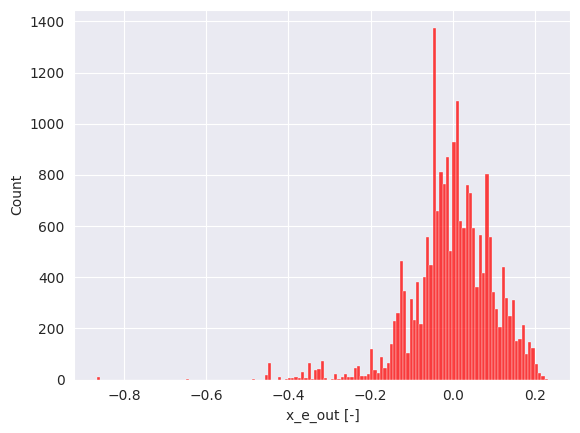

In [144]:
sns.histplot(data,x='x_e_out [-]',color='r')

<AxesSubplot: xlabel='x_e_out [-]', ylabel='Count'>

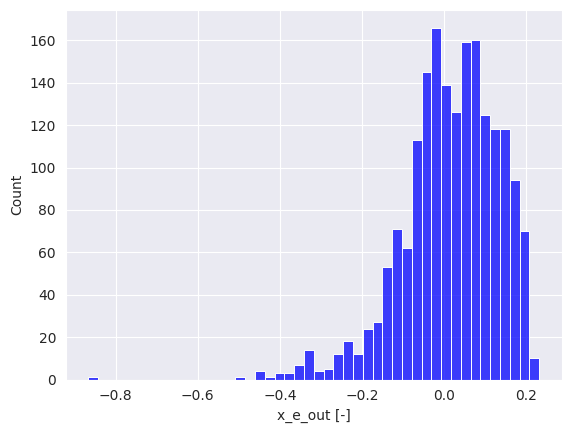

In [145]:
sns.histplot(original,x='x_e_out [-]',color='b')

In [146]:
def get_numerical_features(df):
    numerical_feature = df.select_dtypes(include=['float64'])
    return numerical_feature

numerical_features = get_numerical_features(data)
numerical_features.head()

,pressure [MPa],mass_flux [kg/m2-s],x_e_out [-],D_e [mm],D_h [mm],length [mm],chf_exp [MW/m2]
0,7.00,3770.0,0.1754,NaN,10.8,432.0,3.6
1,NaN,6049.0,-0.0416,10.3,10.3,762.0,6.2
2,13.79,2034.0,0.0335,7.7,7.7,457.0,2.5
3,13.79,3679.0,-0.0279,5.6,15.2,2134.0,3.0
4,13.79,686.0,NaN,11.1,11.1,457.0,2.8


In [147]:
def get_categorical_features(df):
    categorical_features = df.select_dtypes(include=['object'])
    return categorical_features

categorical_features = get_categorical_features(data)
categorical_features.head()

,author,geometry
0,Thompson,tube
1,Thompson,tube
2,Thompson,NaN
3,Beus,annulus
4,NaN,tube


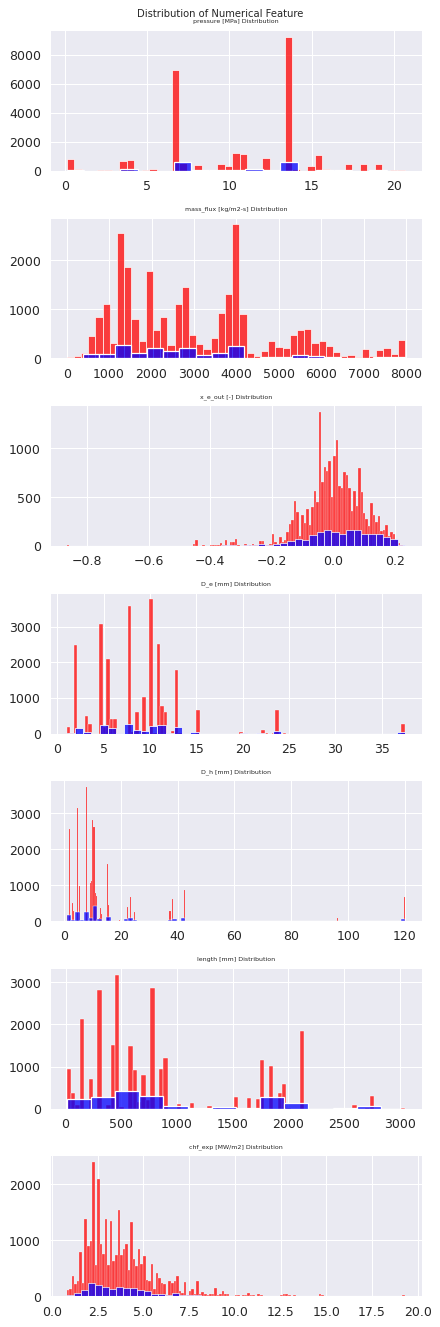

In [148]:
def plot_numerical_histogram():
    fig, ax = plt.subplots(7, 1, figsize = (5, 15), dpi = 90)
    ax = ax.flatten()

    for i, column in enumerate(numerical_features):
        sns.histplot(data[column], ax=ax[i], color='r')
        sns.histplot(original[column], ax=ax[i], color='b')
    
        ax[i].set_title(f'{column} Distribution', size = 5)
        ax[i].set_xlabel(None)
        ax[i].set_ylabel(None)
    
    fig.suptitle('Distribution of Numerical Feature', fontsize = 8)
    plt.tight_layout()
    
plot_numerical_histogram()

In [149]:
def plot_categorical_data(df,column_name,palette,dataset_name):
    fig, ax = plt.subplots(1, 1, figsize = (12, 4))
    #ax = ax.flatten()
    sns.countplot(data = df, y = column_name, ax = ax, palette = palette, 
                  order = data[column_name].value_counts().index)
    ax.yaxis.label.set_size(20)
    plt.yticks(fontsize = 12)
    ax.set_xlabel('Count', fontsize = 20)
    ax.set_ylabel(None)
    plt.xticks(fontsize = 12)

    fig.suptitle(f'{column_name.title()} in {dataset_name} Dataset', fontsize = 15, fontweight = 'bold')
    plt.tight_layout()

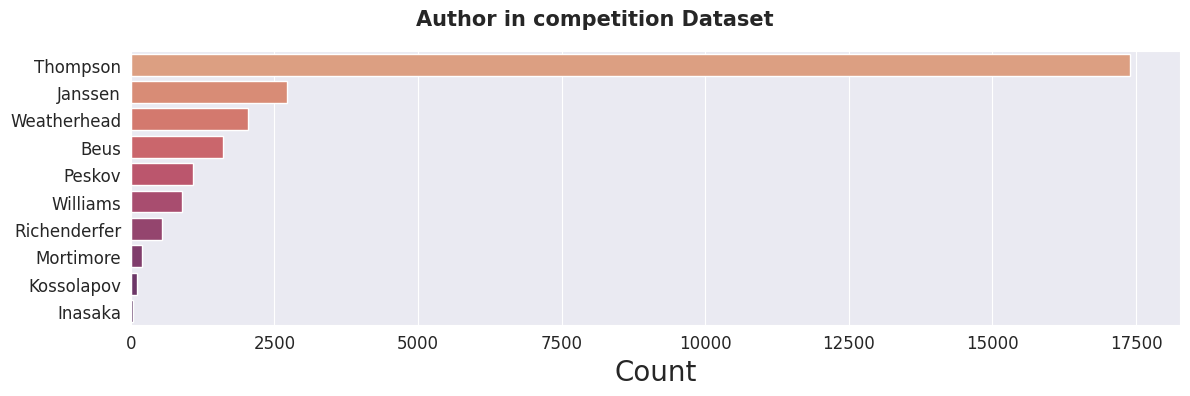

In [150]:
plot_categorical_data(data,'author','flare','competition')

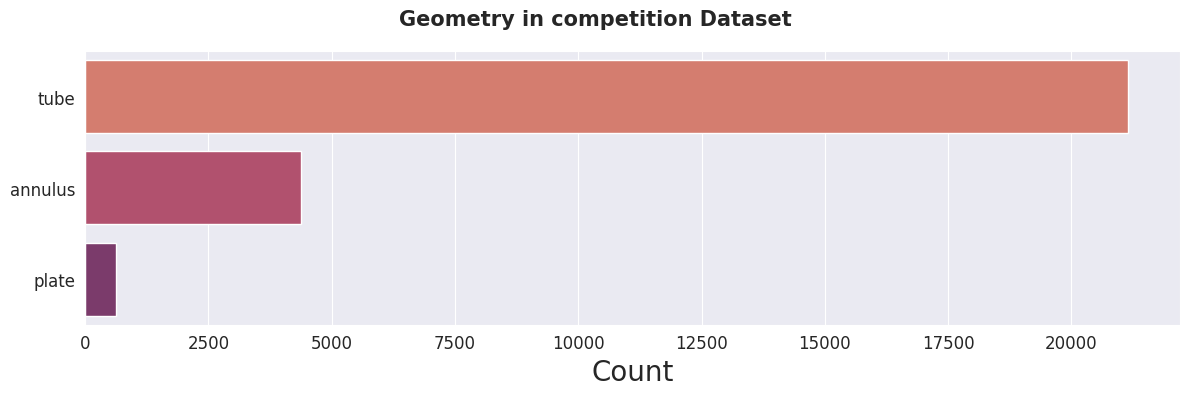

In [151]:
plot_categorical_data(data,'geometry','flare','competition')

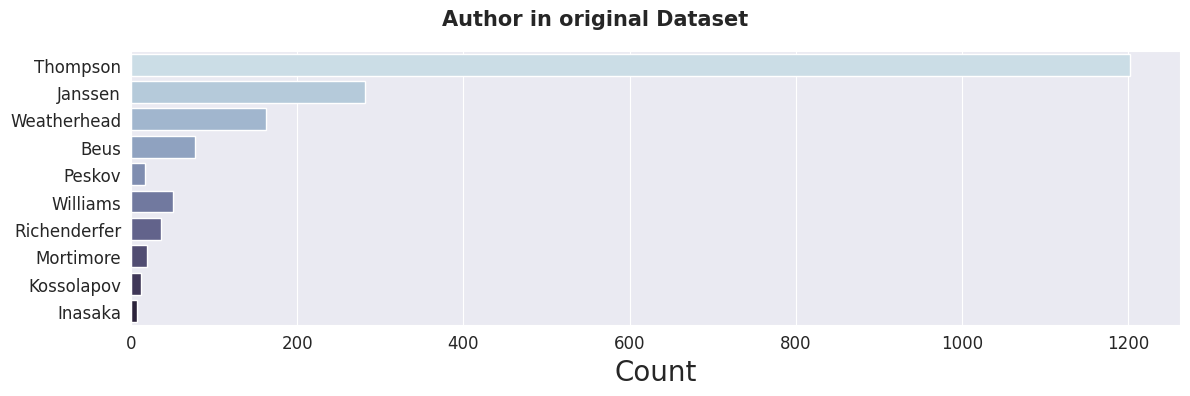

In [152]:
plot_categorical_data(original,'author','ch:s=.25,rot=-.25','original')

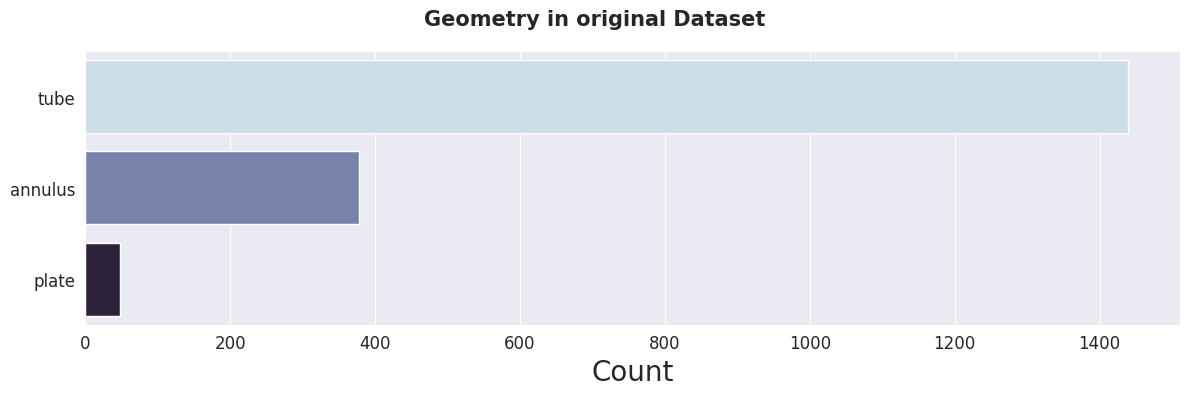

In [153]:
plot_categorical_data(original,'geometry','ch:s=.25,rot=-.25','original')

In [154]:
def show_correlation(dataset, column_name,cmap):
    corr = dataset.corr(method = 'kendall')
    plt.figure(figsize = (10, 10), dpi = 90)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, cmap = cmap, annot = True, annot_kws = {'size' : 12})
    plt.title(f'{column_name} Dataset Correlation Matrix\n', fontsize = 15, weight = 'bold')
    plt.show()

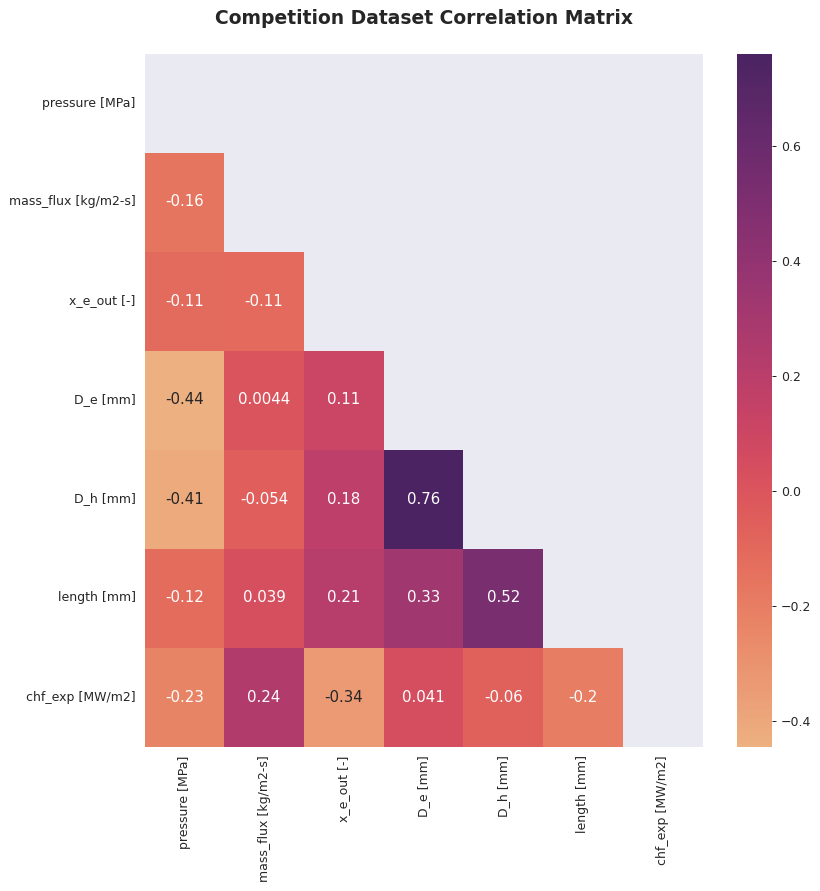

In [155]:
show_correlation(data[numerical_features.columns],'Competition','flare')

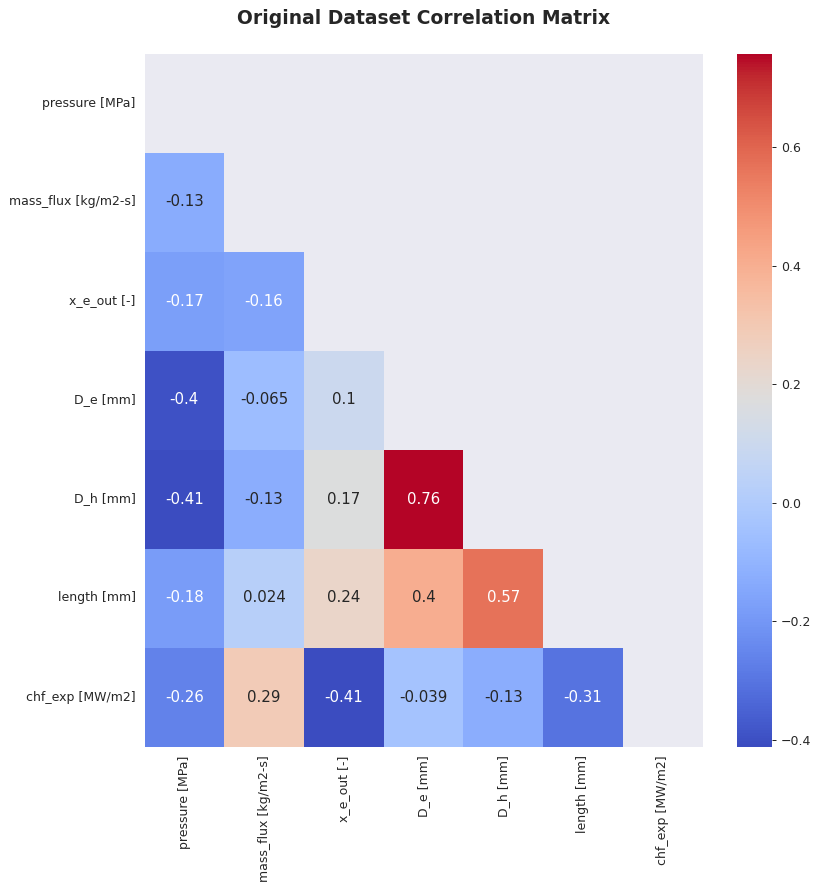

In [156]:
show_correlation(original[numerical_features.columns],'Original','coolwarm')

In [157]:
def generate_train_test_data(data,original):
    
    feature = data[['id','pressure [MPa]', 'mass_flux [kg/m2-s]', 'chf_exp [MW/m2]', 'length [mm]']].copy()
    feature['mass_flux_missing'] = np.where(feature['mass_flux [kg/m2-s]'].isnull(), 1, 0)
    feature['pressure_missing'] = np.where(feature['pressure [MPa]'].isnull(), 1, 0)
    feature['chf_missing'] = np.where(feature['chf_exp [MW/m2]'].isnull(), 1, 0)
    feature['generated'] = 1

    feature_org = original[['id','pressure [MPa]', 'mass_flux [kg/m2-s]', 'chf_exp [MW/m2]', 'length [mm]']].copy()
    feature_org['mass_flux_missing'] = np.where(feature_org['mass_flux [kg/m2-s]'].isnull(), 1, 0)
    feature_org['pressure_missing'] = np.where(feature_org['pressure [MPa]'].isnull(), 1, 0)
    feature_org['chf_missing'] = np.where(feature_org['chf_exp [MW/m2]'].isnull(), 1, 0)
    feature_org['generated'] = 0

    label = data['x_e_out [-]']
    label_org = original['x_e_out [-]']

    X = pd.concat([feature, feature_org], axis = 0).reset_index(drop = True)
    y = pd.concat([label, label_org], axis = 0).reset_index(drop = True)

    X.columns = ['id','pressure', 'mass_flux', 'chf_exp', 'length', 'mass_flux_missing', 'pressure_missing', 'chf_missing','generated']

    test = X[y.isnull()]
    X = X[~y.isnull()]
    y = y[~y.isnull()]
    
    return X,y,test


X,y,test=generate_train_test_data(data,original)

In [158]:
def drop_columns(df,column):
    df =df.drop(columns=[column],axis=1)
    return df
    
X = drop_columns(X,'id')

In [159]:
def remove_null(df,column):
    return df.fillna(df[column].mean(),axis=1,inplace=True)

remove_null(X,'pressure')
remove_null(X,'mass_flux')
remove_null(X,'length')

In [160]:
def split_data(X,y):
    return train_test_split(X,y.to_numpy(),test_size=0.3,random_state=42)
X_train,X_val,y_train,y_val  = split_data(X,y)

In [161]:
def normalize_dataset(X_train,X_val):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    return X_train,X_val

X_train,X_val=normalize_dataset(X_train,X_val)
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(16165, 8) (6929, 8) (16165,) (6929,)


In [162]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [163]:
def convert_to_torch(value):
    return torch.tensor(data=value,dtype=torch.float32,requires_grad=True)


In [164]:
class FluxData(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
            return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)

X_data = convert_to_torch(X_train)
y_data = convert_to_torch(y_train)
X_val = convert_to_torch(X_val)
y_val = convert_to_torch(y_val)
train_data = FluxData(X_data,y_data)
test_data = FluxData(X_val,y_val)

In [165]:
class RMSELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x,y):
        esp = 1e-6
        criterion = torch.nn.MSELoss()
        loss = torch.sqrt(criterion(x,y)) + esp
        return loss

In [166]:
class RegressionFluxModel(torch.nn.Module):
    def training_step(self,batch):
        features,label = batch
        output = self(features)
        loss_object = RMSELoss()
        loss = loss_object(output,label.unsqueeze(1))
        return loss
    
    def validation_step(self,batch):
        features, label = batch 
        output = self(features)                    
        loss_object = RMSELoss()
        loss = loss_object(output,label.unsqueeze(1))    
        return {'Validation_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['Validation_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        return {'Validation_loss': epoch_loss.item()}
    
    
    def epoch_end(self, epoch, result):
        if epoch %10 ==0:
            print("Epoch [{}], Train_loss: {:.5f}, Validation_loss: {:.5f}".format(
                (epoch+10), result['Train_loss'], result['Validation_loss']))
        

In [167]:
class RegressionFluxNNet(RegressionFluxModel):
    def __init__(self,input_features):
        super().__init__()
        self.network = torch.nn.Sequential(
        torch.nn.Linear(input_features,8),
        torch.nn.ReLU(),
        torch.nn.Linear(8,16),
        torch.nn.ReLU(),    
        torch.nn.Linear(16,1)
        )
        
    def forward(self,inputs):
        return self.network(inputs)

In [168]:
model = RegressionFluxNNet(X_train.shape[1])
model.to(device)

RegressionFluxNNet(
  (network): Sequential(
    (0): Linear(in_features=8, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [169]:
BATCH_SIZE = 8
EPOCHS = 200
LEARNING_RATE = 0.001
MOMENTUM = 0.9
OPT_FUNC= torch.optim.Adam
WEIGHT_DECAY = 0.01

In [170]:
def get_dataloaders(dataset_type,batch,shuffle):
    if shuffle:
         return DataLoader(dataset=dataset_type, batch_size=batch, shuffle=True)
    else:
        return DataLoader(dataset=dataset_type, batch_size=batch,shuffle=False)

In [171]:
@torch.no_grad()
def evaluate(model, test_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in test_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, test_loader, opt_func):
    model.train()
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in tqdm(range(epochs)): 
        train_losses = []
        for batch in train_loader:
            optimizer.zero_grad()
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            train_losses.append(loss)
            
        result = evaluate(model, test_loader)
        result['Train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    print('Training is completed!!')
    return history

In [ ]:
train_dataloader = get_dataloaders(train_data,BATCH_SIZE,True)
test_dataloader = get_dataloaders(test_data,BATCH_SIZE,False)
history = fit(EPOCHS, LEARNING_RATE, model, train_dataloader, test_dataloader,OPT_FUNC)

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch [10], Train_loss: 0.08401, Validation_loss: 0.07695
Epoch [20], Train_loss: 0.07467, Validation_loss: 0.07528
Epoch [30], Train_loss: 0.07445, Validation_loss: 0.07492
Epoch [40], Train_loss: 0.07402, Validation_loss: 0.07517
Epoch [50], Train_loss: 0.07382, Validation_loss: 0.07493
Epoch [60], Train_loss: 0.07366, Validation_loss: 0.07422
Epoch [70], Train_loss: 0.07379, Validation_loss: 0.07485


In [ ]:
def plot_losses(history):
    """ Plot the losses in each epoch"""
    train_losses = [x.get('Train_loss') for x in history]
    test_losses = [x['Validation_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(test_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs')
    

plot_losses(history)

In [ ]:
torch.save(model,'/kaggle/working/RegressionFlux.pt')

In [ ]:
test.head()

In [ ]:
remove_null(test,'pressure')
remove_null(test,'mass_flux')
remove_null(test,'length')

In [ ]:
model_test = torch.load('/kaggle/working/RegressionFlux.pt')
model_test.to(device)

In [ ]:
class Data_Test(Dataset):
    def __init__(self, X_test_data):
        self.X_test_data = X_test_data

    def __getitem__(self, index):
        return self.X_test_data[index]
        
    def __len__ (self):
        return len(self.X_test_data)

In [ ]:
def eval_test_data(model,test_data_dl):
    yhat = []
    model.eval()
    with torch.no_grad():
        for X_batch_test in test_data_dl:
            X_batch_test = X_batch_test.to(device)
            y_test_pred = model(X_batch_test)
            yhat.append(torch.round(y_test_pred).cpu().numpy())
    return [a.squeeze().tolist() for a in yhat]

In [ ]:
test_noid = test.drop(columns=['id'],axis=1)

In [ ]:
def normalize_test_dataset(df):
    scaler = StandardScaler()
    X_test = scaler.fit_transform(df)
    #X_val = scaler.transform(X_val)
    return X_test

X_test=normalize_test_dataset(test_noid)
print(X_test.shape)

In [ ]:
testing_data = Data_Test(convert_to_torch(X_test))
testing_data_loader = DataLoader(dataset=testing_data, batch_size=1)

In [ ]:
def submit_test_data():
    submission=[]
    for elements in  eval_test_data(model_test,testing_data_loader):
        submission.append(elements)    
    return submission

In [ ]:
yhat = submit_test_data()
df_submit = pd.DataFrame(data={'id': test['id'].astype(int),'x_e_out [-]': yhat}).to_csv('submission.csv',index=False)
print('Submission Completed!!')